<a href="https://colab.research.google.com/github/c90x/loan_prediction/blob/main/loan_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Dataset - Model

## Dependencies

In [1]:
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Configure theme

In [3]:
plt.style.use("dark_background")

**Download** dataset from Kaggle

In [4]:
import kagglehub

# Download latest version
path = Path(kagglehub.dataset_download("ranadeep/credit-risk-dataset"))

path = path / "loan" / "loan.csv"

assert path.exists()
assert path.is_file()

print("Downloaded dataset to path:", path)

/home/cube/source/dhbw/loan/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloaded dataset to path: /home/cube/.cache/kagglehub/datasets/ranadeep/credit-risk-dataset/versions/3/loan/loan.csv


Load dataset

In [5]:
df = pd.read_csv(path)

/tmp/ipykernel_72343/3280352130.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


## Preprocessing

Select columns

In [ ]:
df_select = [
    "loan_status",  # e
    # 
    "recoveries",
    "collection_recovery_fee",
    "tot_cur_bal",
    "total_rev_hi_lim",
    "sub_grade",
    "earliest_cr_line",
    "issue_d",
    "dti",
    "annual_inc",
    "loan_amnt",
]

df = df[df_select]

Encode `loan_status` and remove rows containing "Issued"

In [ ]:
df = df[df["loan_status"].str.lower() != "issued"]

In [ ]:
# loan_target:
# 0: bad
# 1: good

df_loan_status_good = [
    "current",
    "fully paid",
    "in grace period",
]


def df_loan_status_map(x):
    return 1 if x.lower() in df_loan_status_good else 0


df["loan_target"] = df["loan_status"].map(df_loan_status_map).fillna(0)

In [ ]:
df.drop("loan_status", axis=1, inplace=True)

Target encode `addr_state`

In [ ]:
# Calculate the mean of the target variable for each state
df_state_target_mean = df.groupby("addr_state")["loan_target"].mean()

# Map these means back to the original dataframe
df["addr_state"] = df["addr_state"].map(df_state_target_mean)

Map timespan between `earliest_cr_line` and `issue_d`

In [ ]:
df_date_columns = ["issue_d", "earliest_cr_line"]
for col in df_date_columns:
    df[col] = pd.to_datetime(df[col], format="%b-%Y")

In [ ]:
df["earliest_cr_line_timespan"] = df["issue_d"] - df["earliest_cr_line"]
df["earliest_cr_line_timespan"] = df["earliest_cr_line_timespan"].dt.days / 365.25

In [ ]:
df.drop(df_date_columns, axis=1, inplace=True)

## Model

Split data

In [9]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(["loan_target"], axis=1)
y = df["loan_target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=99
)

Create and train model

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the random forest classifier
clf = RandomForestClassifier(random_state=99, n_estimators=10, max_depth=4)
clf.fit(X_train, y_train)

# Predict on the test data
clf_y_pred = clf.predict(X_test)

Create dummy classifier

In [11]:
from sklearn.dummy import DummyClassifier

# Create and train the dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=99)
dummy_clf.fit(X_train, y_train)

# Predict on the test data
dummy_y_pred = dummy_clf.predict(X_test)

### Classification Report

In [12]:
from sklearn.metrics import classification_report

In [13]:
# Generate the classification report
report = classification_report(
    y_test, clf_y_pred, target_names=["Bad Loans", "Good Loans"]
)
print(report)

              precision    recall  f1-score   support

   Bad Loans       1.00      0.36      0.53     13518
  Good Loans       0.95      1.00      0.97    163958

    accuracy                           0.95    177476
   macro avg       0.98      0.68      0.75    177476
weighted avg       0.95      0.95      0.94    177476



In [14]:
# Evaluate the dummy classifier
dummy_report = classification_report(
    y_test, dummy_y_pred, target_names=["Bad Loans", "Good Loans"], zero_division=0
)
print(dummy_report)

              precision    recall  f1-score   support

   Bad Loans       0.00      0.00      0.00     13518
  Good Loans       0.92      1.00      0.96    163958

    accuracy                           0.92    177476
   macro avg       0.46      0.50      0.48    177476
weighted avg       0.85      0.92      0.89    177476



Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

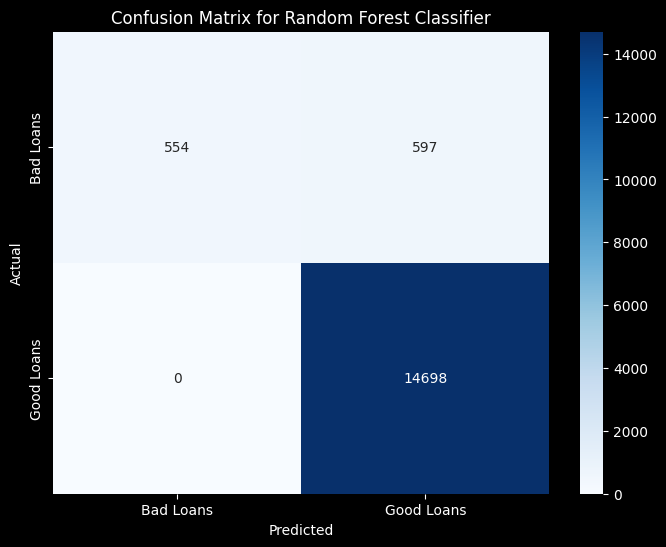

In [ ]:
# Generate the confusion matrix
clf_conf_matrix = confusion_matrix(y_test, clf_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(clf_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad Loans", "Good Loans"], yticklabels=["Bad Loans", "Good Loans"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

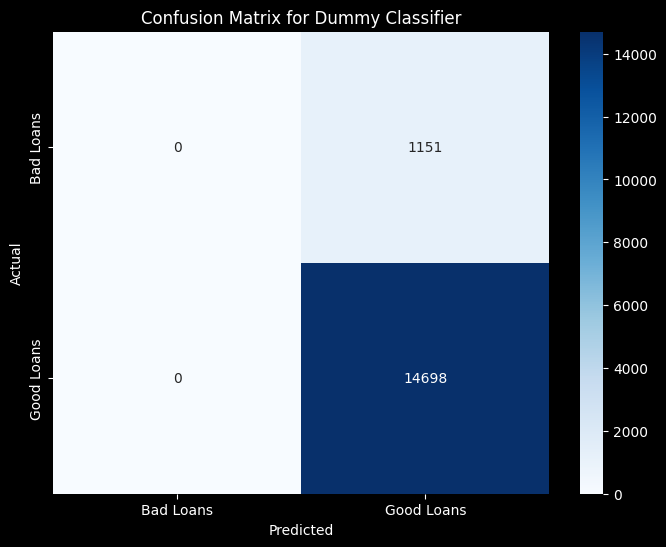

In [ ]:
# Generate the confusion matrix for the dummy classifier
dummy_conf_matrix = confusion_matrix(y_test, dummy_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(dummy_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad Loans", "Good Loans"], yticklabels=["Bad Loans", "Good Loans"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Dummy Classifier")
plt.show()